## Intro

Four outstanding questions:
* Why does Yves Hilpsich not subtract 1 when transforming nominal (log) returns to effective returns? the formula is r_eff = exp(r_log) - 1 but he uses r_eff = exp(r_log)
* I expect the cumulative effective return to be identical to (final_price - orginial price)/original price. I am getting a 1.26% difference. why? 
* Why does Yves Hilpisch use average log returns * 252 to get annualized return rather than use the formula (1+cumulative return)^(365/Days Held) - 
* Also, for algo trading do we use 365/Days Held or 252/Days Held?? 

This model introduces concepts and techniques of backtesting. Backtesting is used to test a strategy's performance on historical data before paper and live trading. 

In [149]:
import numpy as np  # array operations
import pandas as pd  # time series management
import matplotlib.pyplot as plt  # standard plotting library
from matplotlib.pyplot import *
from pylab import plt
plt.style.use('ggplot')
# put all plots in the notebook itself
%matplotlib inline
plt.rcParams['figure.figsize'] = (16.0, 10.0)

## Retreiving Index Level Data

In [2]:
symbol = 'AAPL.O'
data = pd.read_csv('https://hilpisch.com/tr_eikon_eod_data.csv',
                    index_col = 0, parse_dates = True)[symbol].dropna()
data = pd.DataFrame(data)
data.tail()

,AAPL.O
Date,
2018-06-25,182.17
2018-06-26,184.43
2018-06-27,184.16
2018-06-28,185.50
2018-06-29,185.11


## Generating Trading Signals

We want to implement a simple trading strategy based on simple moving averages (SMA):
* Short-term SMA oer 42 days (SMA42)
* Long-term SMA over 252 days (SMA252)
We distinguish two constellations: 
* SMA42 > SMA252: buy signal, having a long position in the market
* SMA42 < SMA252: sell signal, having a short position in the market

In [3]:
data['SMA42'] = data['AAPL.O'].rolling(42).mean()
data['SMA252'] = data['AAPL.O'].rolling(252).mean()
data.dropna(inplace = True)
data

,AAPL.O,SMA42,SMA252
Date,,,
2010-12-31,46.079954,45.280967,37.120735
2011-01-03,47.081381,45.349708,37.186246
2011-01-04,47.327096,45.412599,37.252521
2011-01-05,47.714238,45.466102,37.322266
2011-01-06,47.675667,45.522565,37.392079
2011-01-07,48.017095,45.582089,37.462453
2011-01-10,48.922094,45.671800,37.537478
2011-01-11,48.805665,45.752106,37.613397
2011-01-12,49.202808,45.846544,37.689230


In graphical terms, we want to be long everytime the SMA42 line is above the SMA252 line and vice versa

To formalize position representation, we will use +1 and -1 for long and short positions respectively. 

In [4]:
data['position'] = np.where(data['SMA42'] > data['SMA252'], 1, -1)

(-1.1, 1.1)

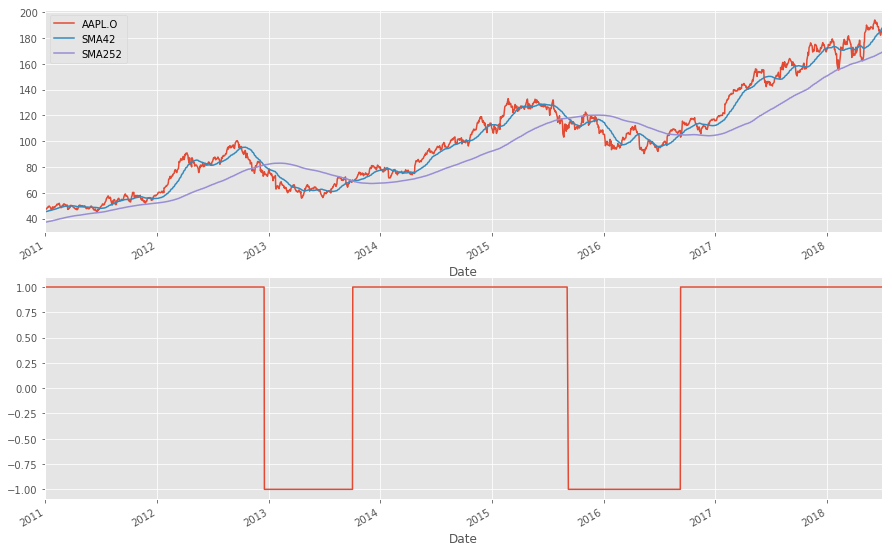

In [5]:
fix, axes = plt.subplots(nrows=2, ncols=1)
data[[symbol,'SMA42', 'SMA252']].plot(ax = axes[0], figsize = (15,10))
data['position'].plot(ax = axes[1], figsize = (15,10))
plt.ylim(-1.1, 1.1)

## Backtesting = Judging Performance

To evaluate performance, we need to calculate the log returns (market returns), i.e., if we buy and hold. 

In [6]:
data['market'] = (np.log(data[symbol])).diff()
#data['market'] = np.log(data[symbol] / data[symbol].shift(1))
#data['market'] = np.log(data[symbol].pct_change()+1)

Now let's calculate the strategy returns. These depend on our position in the market. We are ignorning transaction costs here. 
Remember that we started with retreiving End of Day prices. So to avoid look-ahead bias, a long position taken yesterday based on end of day price, will tell us how much the strategy return is today. 

In [7]:
data['strategy'] = data['position'].shift(1) * data['market']

Now let's calculate the cumulative returns of the market vs the strategy. To do that we need to calculate the cumulative sum of log returns then apply the exponential function. Check out these two sources if you wish to understand more about how to calculate cumulative returns:
* https://www.quantconnect.com/tutorials/introduction-to-financial-python/rate-of-return,-mean-and-variance
* https://quantivity.wordpress.com/2011/02/21/why-log-returns/


In [8]:
data['marketCumlReturn'] = data['market'].cumsum().apply(np.exp)
data['strategyCumlReturn'] = data['strategy'].cumsum().apply(np.exp)

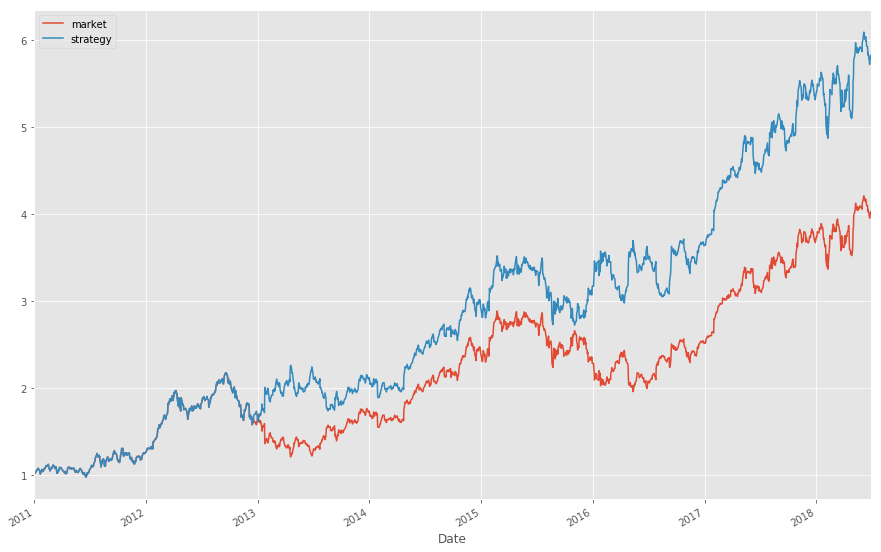

In [9]:
(data[['market','strategy']].cumsum().apply(np.exp)).plot(figsize=(15,10))

## Risk and Return

The evaluation of a strategy is not complete until risk (volatility and drawdown) is evaluated and incorporated. For example, an earning of 10% with 1% risk may be a better option than an earning of 20% with 3% risk. 

To compare two strategies we usually need to compare the annualised return/risk couple. 

Let's start with the annualised return (see this link for how to calcualte annualised return from cumulative return: https://www.investopedia.com/terms/a/annualized-total-return.asp)

In [10]:
tradingDaysYear = 252
dataTotalTradingDays = len(data.index)

marketAnnReturn = np.power(1 + data['marketCumlReturn'][-1], tradingDaysYear/dataTotalTradingDays)-1
marketAnnReturn

0.24034567559353892

What if we use total days a year and total days between begining and end of data time stamps to calculate annulised return?

In [11]:
totalDaysYear = 365
dataTotalDays = (data.index[-1] - data.index[0] ).days
marketAnnReturn = np.power(1 + data['marketCumlReturn'][-1], totalDaysYear/dataTotalDays)-1
marketAnnReturn

0.23997039921523178

Gives pretty much the same value. 

In [12]:
strategyAnnReturn = np.power(1 + data['strategyCumlReturn'][-1], tradingDaysYear/dataTotalTradingDays)-1
strategyAnnReturn

0.2920340350195121

In [13]:
print(f'Market annulised return is {"{:.2f}".format(marketAnnReturn*100)}% \nStrategy annualised return is {"{:.2f}".format(strategyAnnReturn*100)}%')

Market annulised return is 24.00% 
Strategy annualised return is 29.20%


However, if we use the average daily return and mutliply by total trading days a year we get  different values!

In [14]:
arets = data[['market', 'strategy']].mean() * 252  # annualized returns
arets

market      0.185803
strategy    0.235138
dtype: float64

Annualized volatility is obtained by mutliplying daily volatility by sqaure roote of 252 (total trading days a year)

In [15]:
astds = data[['market', 'strategy']].std() * 252 ** 0.5  # annualized volatility
astds

market      0.250571
strategy    0.250407
dtype: float64

In [16]:
print((f'market: {"{:.2f}".format(marketAnnReturn*100)}%  annualised return and  {"{:.4f}".format(100*astds[0])}% annualised volatility'
f'\nstrategy: {"{:.2f}".format(strategyAnnReturn*100)}%  annualised return and  {"{:.4f}".format(100*astds[1])}% annualised volatility'))

market: 24.00%  annualised return and  25.0571% annualised volatility
strategy: 29.20%  annualised return and  25.0407% annualised volatility


As the annualised volitility is almost the same, the strategy has better performance. 

## Optimal SMA values

I will apply an optimization procedure to find the optimal SMA values for the Argo Blockchain stock. 

In [17]:
import pandas_datareader.data as web
from pandas_datareader import data as pdr
import datetime as dt

start = dt.datetime(2020, 8, 12)
end = dt.datetime.now()
stock = pdr.get_data_yahoo('ARB'+'.L', start, end)
stockClose = pd.DataFrame(stock.Close)

Splitting the data into training and testing datasets

In [18]:
splitNumber = np.int(0.8*len(stock.Close.index))
trainStockClose = stockClose.iloc[:splitNumber,:]
testStockClose = stockClose.iloc[splitNumber:,:]

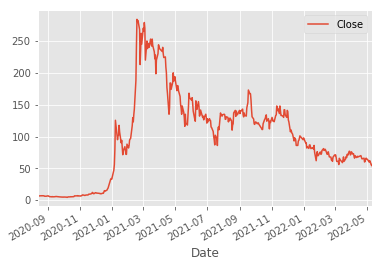

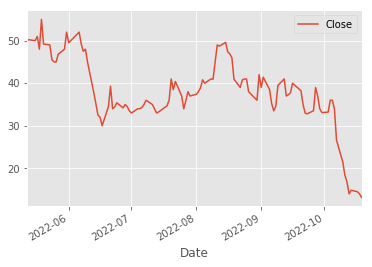

In [19]:
trainStockClose.plot()
testStockClose.plot()

In [20]:
def strategy(df, shortPeriod, longPeriod): 
    ''' Identifies trading signals and calculates the market's (buy and hold) and the strategy's (simple moving average crossover) effective returns
    
    Arguemnts: 
        * df: dataframe containing the close price data of the chosen stock
        * shortPeriod (integer): the period to calculate the short simple moving average
        * longPeriod (integer): the period to calculate the long simple moving average
    Returns:
        * df: dataframe containing:
            - close price data of the stock
            - short and long simple moving averages (two columns)
            - position: long position of our strategy (1 for long and 0 for not trading - we are never short)
            - marketNomReturn: the nominal return obtained if we buy and hold the stock
            - strategyNomReturn: the nominal return obtained if we use the strategy to trade
            - marketEffReturn: the effective return obtained if we buy and hold the stock
            - strategyEffReturn: the effective return obtained if we use the strategy to trade 
            - marketCumlEffReturn: the cumulative effective return obtained if we buy and hold the stock
            - strategyCumlEffReturn: the cumulative effective return obtained if we use the strategy to trade 
    
     '''
    df = df.copy()
    df['SMA_short'] = df.Close.rolling(shortPeriod).mean()
    df['SMA_long'] = df.Close.rolling(longPeriod).mean()
    df = df.dropna()
    df['position'] = np.where(df['SMA_short'] > df['SMA_long'], 1, 0)
    df['marketNomReturn'] = (np.log(df.Close)).diff()
    df['strategyNomReturn'] = df['position'].shift(1)*df['marketNomReturn']
    df[['marketEffReturn', 'strategyEffReturn']] = (df[['marketNomReturn', 'strategyNomReturn']]).apply(np.exp) - 1
    df[['marketCumlEffReturn', 'strategyCumlEffReturn']] = (df[['marketNomReturn', 'strategyNomReturn']].cumsum()).apply(np.exp)-1 
    df = df.dropna()

    return df



In [21]:
tradingDaysYear = 252

def performance(df):
    ''' Assesses the performance of the market and strategy trades by calculating the annualized return and the volatility.
    Arguemnts: 
        * df: dataframe containing:
            - close price data of the stock
            - short and long simple moving averages (two columns)
            - position: long position of our strategy (1 for long and 0 for not trading - we are never short)
            - marketNomReturn: the nominal return obtained if we buy and hold the stock
            - strategyNomReturn: the nominal return obtained if we use the strategy to trade
            - marketEffReturn: the effective return obtained if we buy and hold the stock
            - strategyEffReturn: the effective return obtained if we use the strategy to trade 
            - marketCumlEffReturn: the cumulative effective return obtained if we buy and hold the stock
            - strategyCumlEffReturn: the cumulative effective return obtained if we use the strategy to trade 
    
    Returns:
        * [marketAnnReturn, strategyAnnReturn]: list of market and strategy's annualized returns
        *  [marketVolatility, strategyVolatility]: list of market and strategy's annual volatility
    
     '''
    dataTotalTradingDays = len(df.index)
    marketAnnReturn = np.power(1 + df['marketCumlEffReturn'][-1], tradingDaysYear/dataTotalTradingDays)-1 
    strategyAnnReturn = np.power(1 + df['strategyCumlEffReturn'][-1], tradingDaysYear/dataTotalTradingDays)-1 
    marketVolatility = df['marketEffReturn'].std() * tradingDaysYear ** 0.5
    strategyVolatility = df['strategyEffReturn'].std() * tradingDaysYear ** 0.5
    return [marketAnnReturn, strategyAnnReturn], [marketVolatility, strategyVolatility]


In [22]:
riskFreeRate = 0.0437 #United Kingdom 10Y Government Bond has a 4.371% yield
def performanceEvaluation(performanceResults):
    ''' Compares performance of the market and strategy performance by calculating the sharpe ratio.
    Arguemnts: 
        * [marketAnnReturn, strategyAnnReturn]: list of market and strategy's annualized returns and volatility
    Returns:
        * marketSharpe: sharpe ratio for market
        * strategySharpe: sharpe ratio for strategy
    
     '''
    marketSharpe = (performanceResults[0][0] - riskFreeRate)/performanceResults[1][0]
    strategySharpe = (performanceResults[0][1] - riskFreeRate)/performanceResults[1][1]
    return marketSharpe, strategySharpe


In [23]:
def plotTrades(df):
    ''' Plots the Close Price, short and long moving averages and the position: 
        * df: dataframe containing:
            - close price data of the stock
            - short and long simple moving averages (two columns)
            - position: long position of our strategy (1 for long and 0 for not trading - we are never short)
            - marketNomReturn: the nominal return obtained if we buy and hold the stock
            - strategyNomReturn: the nominal return obtained if we use the strategy to trade
            - marketEffReturn: the effective return obtained if we buy and hold the stock
            - strategyEffReturn: the effective return obtained if we use the strategy to trade 
            - marketCumlEffReturn: the cumulative effective return obtained if we buy and hold the stock
            - strategyCumlEffReturn: the cumulative effective return obtained if we use the strategy to trade 
    
    Returns:
     '''
    fig, ax = plt.subplots(figsize = (15,10))
    ax2 = ax.twinx()
    ax.plot(df[['Close','SMA_short','SMA_long']])
    ax2.plot(df['position'], 'k--')

In [24]:
sharpe = []
shortSMA_values = []
longSMA_values = []
shortSMA_list =  range(2, 21, 1)
longSMA_list =  range(30, 150, 5)

for i_short, i_long in zip(shortSMA_list, longSMA_list): 
    performanceResults = performance(strategy(trainStockClose,i_short,i_long))
    sharpe.append(performanceEvaluation(performanceResults))
    shortSMA_values.append(i_short)
    longSMA_values.append(i_long)

results = pd.DataFrame(sharpe,[shortSMA_values, longSMA_values],columns=['Market', 'Strategy'])
results.index.set_names(['Short SMA', 'Long SMA'],inplace = True)
marketBestPeriods, strategyBestPeriods = results.idxmax() # find the index of the optimal long and short SMA values


### Evaluate performance on training set

market: 344.02%  annualised return and  148.5939% annualised volatility
strategy: 643.23%  annualised return and  122.7435% annualised volatility


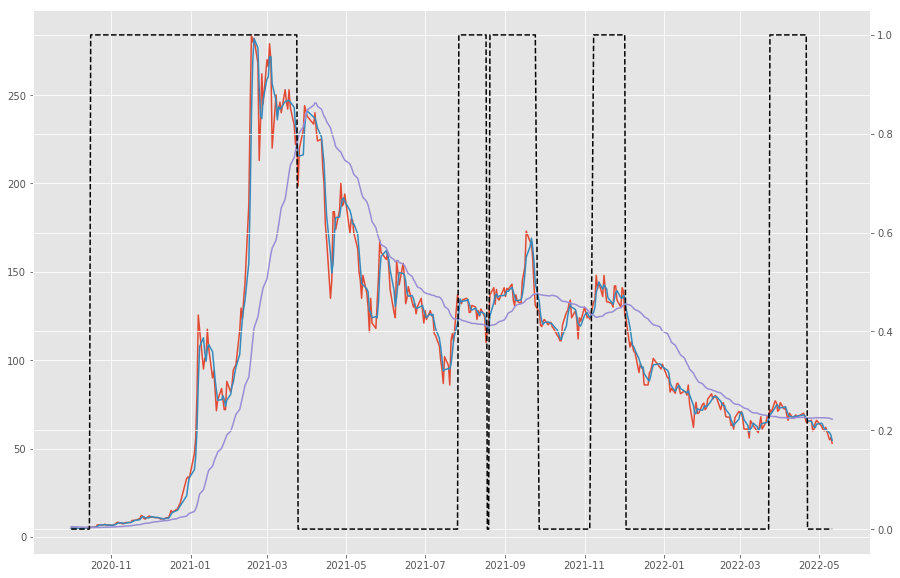

In [25]:
df = strategy(trainStockClose,strategyBestPeriods[0], strategyBestPeriods[1])
plotTrades(df)
performanceResults = performance(df)
performanceResults
print((f'market: {"{:.2f}".format(performanceResults[0][0]*100)}%  annualised return and  {"{:.4f}".format(100*performanceResults[1][0])}% annualised volatility'
f'\nstrategy: {"{:.2f}".format(performanceResults[0][1]*100)}%  annualised return and  {"{:.4f}".format(100*performanceResults[1][1])}% annualised volatility'))


### Evaluate performance on test set

market: -95.26%  annualised return and  114.8192% annualised volatility
strategy: -47.90%  annualised return and  49.8228% annualised volatility


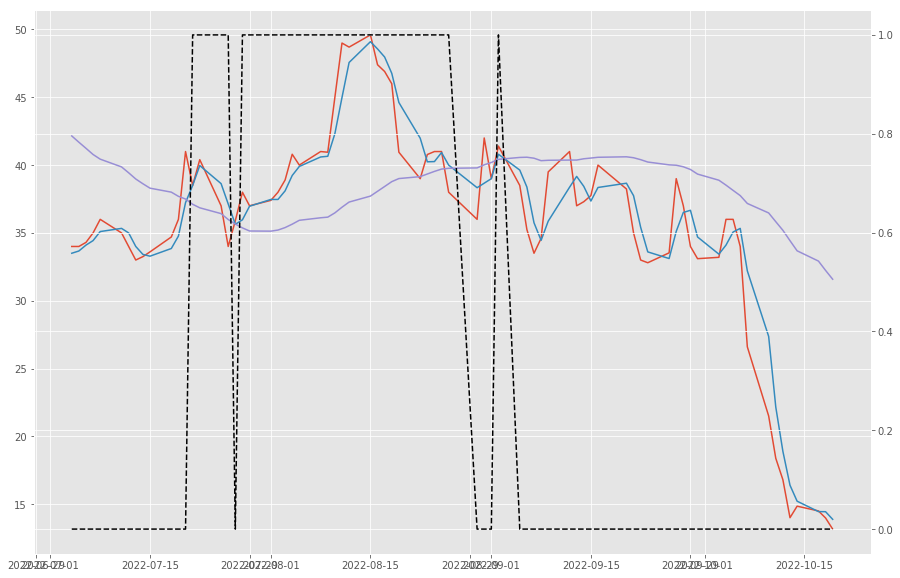

In [26]:
df2 = strategy(testStockClose,strategyBestPeriods[0], strategyBestPeriods[1])
plotTrades(df2)
performanceResults = performance(df2)
performanceResults
print((f'market: {"{:.2f}".format(performanceResults[0][0]*100)}%  annualised return and  {"{:.4f}".format(100*performanceResults[1][0])}% annualised volatility'
f'\nstrategy: {"{:.2f}".format(performanceResults[0][1]*100)}%  annualised return and  {"{:.4f}".format(100*performanceResults[1][1])}% annualised volatility'))


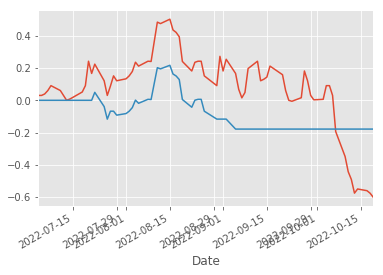

In [27]:
df2.marketCumlEffReturn.plot()
df2.strategyCumlEffReturn.plot()

Though the strategy limits the losses by getting out of a loosing position, the market (buy and hold) approach reaches higher return levels (>40%). 

It seems like we have trained the dataset on a bullish market and tested it on a bearish market. In both cases, the moving average strategy had a better overall return (higher returns in bullish market and smaller losses in bearish market). However, if we have a better exit signal, we might be able to change that and profit in both market regimes. 


Shout out to part time larry for the pyAlgo tutorial: https://www.youtube.com/watch?v=JcHOOEhaDtU


In [28]:
from pyalgotrade import strategy
from pyalgotrade.barfeed import yahoofeed
from pyalgotrade.technical import ma
from pyalgotrade.stratanalyzer import returns, drawdown, trades

In [29]:


class buyAndHoldStrategy(strategy.BacktestingStrategy): #basically this is a class (template) of the trading strategy we are coding
    def __init__(self, feed, instrument):
        super(buyAndHoldStrategy, self).__init__(feed)
        self.instrument = instrument
        self.setUseAdjustedValues(True) #use adjusted close price after split/dividend operations
        self.position = None #the state of the strategy
    
    def onEnterOk(self, position):
        self.info(f"{position.getEntryOrder().getExecutionInfo()}")

    def onBars(self, bars): #models what to do everytime a new databar arrives
        bar = bars[self.instrument]
        self.info(bar.getClose()) #it is like the print method but allows to register a timestamp

        if self.position is None:
            close = bar.getAdjClose()
            broker = self.getBroker()
            cash = broker.getCash()
            quantity = cash/close
            
            self.position = self.enterLong(self.instrument, quantity)





In [30]:
start = dt.datetime(1999, 5, 1)
end = dt.datetime(2019,10,4)
data = pdr.get_data_yahoo('SPY', start, end)
data.to_csv("spy.csv")

feed = yahoofeed.Feed()
feed.addBarsFromCSV("spy", "spy.csv")
strategy = buyAndHoldStrategy(feed, "spy") #initialize the strategy
strategy.run()

1999-05-03 00:00:00 strategy [INFO] 135.6875
1999-05-04 00:00:00 strategy [INFO] 1999-05-04 00:00:00 - Price: 88.22403318458629 - Amount: 11287 - Fee: 0
1999-05-04 00:00:00 strategy [INFO] 133.75
1999-05-05 00:00:00 strategy [INFO] 134.8125
1999-05-06 00:00:00 strategy [INFO] 133.984375
1999-05-07 00:00:00 strategy [INFO] 135.0
1999-05-10 00:00:00 strategy [INFO] 134.328125
1999-05-11 00:00:00 strategy [INFO] 135.6875
1999-05-12 00:00:00 strategy [INFO] 136.75
1999-05-13 00:00:00 strategy [INFO] 137.34375
1999-05-14 00:00:00 strategy [INFO] 133.78125
1999-05-17 00:00:00 strategy [INFO] 134.1875
1999-05-18 00:00:00 strategy [INFO] 133.9375
1999-05-19 00:00:00 strategy [INFO] 134.90625
1999-05-20 00:00:00 strategy [INFO] 134.09375
1999-05-21 00:00:00 strategy [INFO] 133.34375
1999-05-24 00:00:00 strategy [INFO] 131.125
1999-05-25 00:00:00 strategy [INFO] 129.0
1999-05-26 00:00:00 strategy [INFO] 130.4375
1999-05-27 00:00:00 strategy [INFO] 128.5625
1999-05-28 00:00:00 strategy [INFO] 130

In [31]:
print(strategy.getBroker().getEquity()+ strategy.getBroker().getCash()) 

3174546.8106638547


In [104]:
lstDayOfMonth = []
for i_dt in range(0,len(data.index)):
    try:
        if data.index[i_dt+1].month - data.index[i_dt].month > 0:
            lstDayOfMonth.append(data.index[i_dt].to_pydatetime().date().isoformat())
    except:
        pass


In [33]:
# fig, ax = plt.subplots(figsize = (15,10))
# ax.plot(data.Close)
# ax.plot(data.loc[lstDayOfMonth].Close,'b*')


In [150]:
from pyalgotrade import strategy
from pyalgotrade.barfeed import yahoofeed
from pyalgotrade.technical import ma
from pyalgotrade.stratanalyzer import returns, drawdown, trades, sharpe
from pyalgotrade import plotter

class MovingAverageStrategy(strategy.BacktestingStrategy):
    def __init__(self, feed, instrument):
        super(MovingAverageStrategy, self).__init__(feed)
        self.instrument = instrument
        self.position = None
        self.setUseAdjustedValues(True)
        self.__prices = feed[instrument].getPriceDataSeries()
        self.ma = ma.SMA(self.__prices, 200)
        

    def onEnterOk(self, position):
        execInfo = position.getEntryOrder().getExecutionInfo()
        self.info(f"===== BUY at {execInfo.getPrice()} {execInfo.getQuantity()} =====")

    def onExitOk(self, position):
        execInfo = position.getExitOrder().getExecutionInfo()
        self.info(f"===== SELL at {execInfo.getPrice()} =====")
        self.position = None
    
    def onBars(self, bars):

        if self.ma[-1] is None:
            return
        
        bar = bars[self.instrument]
        close = bar.getAdjClose()
        date = bar.getDateTime().date().isoformat()
        
        if date in lstDayOfMonth:
            if self.position is None:
                broker = self.getBroker()
                cash = broker.getCash() * 0.98 #

                if close > self.ma[-1]:
                    quantity = cash/close
                    self.info(f"buying at {close}, which is above {self.ma[-1]}")
                    self.position = self.enterLong(self.instrument, quantity)
            elif close < self.ma[-1] and self.position is not None:
                self.info(f"selling at {close}, which is below {self.ma[-1]}")
                self.position.exitMarket()
                self.position = None


In [151]:
start = dt.datetime(1999, 5, 1)
end = dt.datetime(2019,10,4)
data = pdr.get_data_yahoo('SPY', start, end)
data.to_csv("spy.csv")


2000-02-29 00:00:00 strategy [INFO] buying at 90.47978973388672, which is above 89.51375423431395
2000-03-01 00:00:00 strategy [INFO] ===== BUY at 90.60321854361024 10831 =====
2000-09-29 00:00:00 strategy [INFO] selling at 95.2554702758789, which is below 95.72172248840324
2000-10-02 00:00:00 strategy [INFO] ===== SELL at 95.6907111098915 =====
2002-03-28 00:00:00 strategy [INFO] buying at 77.38067626953125, which is above 76.88256664276119
2002-04-01 00:00:00 strategy [INFO] ===== BUY at 77.1847175490764 13362 =====
2002-04-30 00:00:00 strategy [INFO] selling at 72.8805160522461, which is below 76.12277725219728
2002-05-01 00:00:00 strategy [INFO] ===== SELL at 72.95484707798943 =====
2003-04-30 00:00:00 strategy [INFO] buying at 63.16117477416992, which is above 60.2295973587035
2003-05-01 00:00:00 strategy [INFO] ===== BUY at 63.16806922633221 15493 =====
2008-01-31 00:00:00 strategy [INFO] selling at 102.79844665527344, which is below 110.24409915924068
2008-02-01 00:00:00 strateg

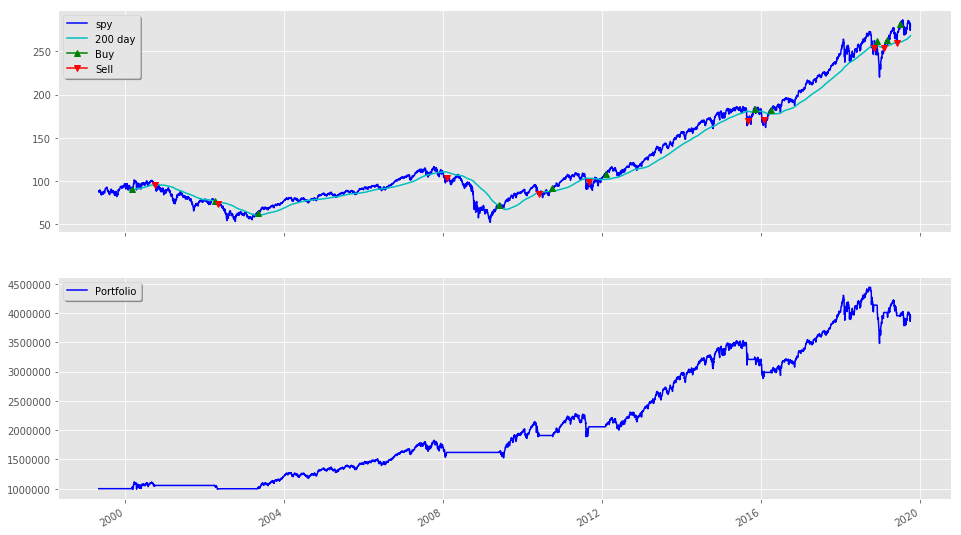

Final portfolio value: $3941749.68
Cumulative returns: 294.17 %
Sharpe ratio: 0.21
Max. drawdown: 21.69 %
Longest drawdown duration: 1253 days, 0:00:00

Total trades: 10
Avg. profit: $295459
Profits std. dev.: $483385
Max. profit: $1150626
Min. profit: $-221394
Avg. return: 17 %
Returns std. dev.: 25 %
Max. return: 63 %
Min. return: -7 %

Profitable trades: 6
Avg. profit: $568912
Profits std. dev.: $446566
Max. profit: $1150626
Min. profit: $55103
Avg. return: 32 %
Returns std. dev.: 23 %
Max. return: 63 %
Min. return:  6 %

Unprofitable trades: 4
Avg. loss: $-114721
Losses std. dev.: $67872
Max. loss: $-221394
Min. loss: $-55233
Avg. return: -4 %
Returns std. dev.:  2 %
Max. return: -1 %
Min. return: -7 %


In [152]:

feed = yahoofeed.Feed()
feed.addBarsFromCSV("spy", "spy.csv")
strategy = MovingAverageStrategy(feed, "spy")

retAnalyzer = returns.Returns()
sharpeRatioAnalyzer = sharpe.SharpeRatio()
drawDownAnalyzer = drawdown.DrawDown()
tradesAnalyzer = trades.Trades()

strategy.attachAnalyzer(retAnalyzer)
strategy.attachAnalyzer(sharpeRatioAnalyzer)
strategy.attachAnalyzer(drawDownAnalyzer)
strategy.attachAnalyzer(tradesAnalyzer)


plt = plotter.StrategyPlotter(strategy)

plt.getInstrumentSubplot("spy").addDataSeries("200 day", strategy.ma)

strategy.run()

plt.plot()



print ("Final portfolio value: $%.2f" % strategy.getResult())
print ("Cumulative returns: %.2f %%" % (retAnalyzer.getCumulativeReturns()[-1] * 100))
print ("Sharpe ratio: %.2f" % (sharpeRatioAnalyzer.getSharpeRatio(0.05)))
print ("Max. drawdown: %.2f %%" % (drawDownAnalyzer.getMaxDrawDown() * 100))
print ("Longest drawdown duration: %s" % (drawDownAnalyzer.getLongestDrawDownDuration()))

print("")
print ("Total trades: %d" % (tradesAnalyzer.getCount()))
if tradesAnalyzer.getCount() > 0:
    profits = tradesAnalyzer.getAll()
    print ("Avg. profit: $%2.f" % (profits.mean()))
    print ("Profits std. dev.: $%2.f" % (profits.std()))
    print ("Max. profit: $%2.f" % (profits.max()))
    print ("Min. profit: $%2.f" % (profits.min()))
    returns = tradesAnalyzer.getAllReturns()
    print ("Avg. return: %2.f %%" % (returns.mean() * 100))
    print ("Returns std. dev.: %2.f %%" % (returns.std() * 100))
    print ("Max. return: %2.f %%" % (returns.max() * 100))
    print ("Min. return: %2.f %%" % (returns.min() * 100))

print()
print ("Profitable trades: %d" % (tradesAnalyzer.getProfitableCount()))
if tradesAnalyzer.getProfitableCount() > 0:
    profits = tradesAnalyzer.getProfits()
    print ("Avg. profit: $%2.f" % (profits.mean()))
    print ("Profits std. dev.: $%2.f" % (profits.std()))
    print ("Max. profit: $%2.f" % (profits.max()))
    print ("Min. profit: $%2.f" % (profits.min()))
    returns = tradesAnalyzer.getPositiveReturns()
    print ("Avg. return: %2.f %%" % (returns.mean() * 100))
    print ("Returns std. dev.: %2.f %%" % (returns.std() * 100))
    print ("Max. return: %2.f %%" % (returns.max() * 100))
    print ("Min. return: %2.f %%" % (returns.min() * 100))

print()
print ("Unprofitable trades: %d" % (tradesAnalyzer.getUnprofitableCount()))
if tradesAnalyzer.getUnprofitableCount() > 0:
    losses = tradesAnalyzer.getLosses()
    print ("Avg. loss: $%2.f" % (losses.mean()))
    print ("Losses std. dev.: $%2.f" % (losses.std()))
    print ("Max. loss: $%2.f" % (losses.min()))
    print ("Min. loss: $%2.f" % (losses.max()))
    returns = tradesAnalyzer.getNegativeReturns()
    print ("Avg. return: %2.f %%" % (returns.mean() * 100))
    print ("Returns std. dev.: %2.f %%" % (returns.std() * 100))
    print ("Max. return: %2.f %%" % (returns.max() * 100))
    print ("Min. return: %2.f %%" % (returns.min() * 100))

In [135]:
a = strategy.getBroker()

In [112]:
a.getCash()

30596.172227927484